## House Price Prediction
Goal
It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

Metric
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

### About the Dataset

SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
MSSubClass: The building class
MSZoning: The general zoning classification
LotFrontage: Linear feet of street connected to property
LotArea: Lot size in square feet
Street: Type of road access
Alley: Type of alley access
LotShape: General shape of property
LandContour: Flatness of the property
Utilities: Type of utilities available
LotConfig: Lot configuration
LandSlope: Slope of property
Neighborhood: Physical locations within Ames city limits
Condition1: Proximity to main road or railroad
Condition2: Proximity to main road or railroad (if a second is present)
BldgType: Type of dwelling
HouseStyle: Style of dwelling
OverallQual: Overall material and finish quality
OverallCond: Overall condition rating
YearBuilt: Original construction date
YearRemodAdd: Remodel date
RoofStyle: Type of roof
RoofMatl: Roof material
Exterior1st: Exterior covering on house
Exterior2nd: Exterior covering on house (if more than one material)
MasVnrType: Masonry veneer type
MasVnrArea: Masonry veneer area in square feet
ExterQual: Exterior material quality
ExterCond: Present condition of the material on the exterior
Foundation: Type of foundation
BsmtQual: Height of the basement
BsmtCond: General condition of the basement
BsmtExposure: Walkout or garden level basement walls
BsmtFinType1: Quality of basement finished area
BsmtFinSF1: Type 1 finished square feet
BsmtFinType2: Quality of second finished area (if present)
BsmtFinSF2: Type 2 finished square feet
BsmtUnfSF: Unfinished square feet of basement area
TotalBsmtSF: Total square feet of basement area
Heating: Type of heating
HeatingQC: Heating quality and condition
CentralAir: Central air conditioning
Electrical: Electrical system
1stFlrSF: First Floor square feet
2ndFlrSF: Second floor square feet
LowQualFinSF: Low quality finished square feet (all floors)
GrLivArea: Above grade (ground) living area square feet
BsmtFullBath: Basement full bathrooms
BsmtHalfBath: Basement half bathrooms
FullBath: Full bathrooms above grade
HalfBath: Half baths above grade
Bedroom: Number of bedrooms above basement level
Kitchen: Number of kitchens
KitchenQual: Kitchen quality
TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
Functional: Home functionality rating
Fireplaces: Number of fireplaces
FireplaceQu: Fireplace quality
GarageType: Garage location
GarageYrBlt: Year garage was built
GarageFinish: Interior finish of the garage
GarageCars: Size of garage in car capacity
GarageArea: Size of garage in square feet
GarageQual: Garage quality
GarageCond: Garage condition
PavedDrive: Paved driveway
WoodDeckSF: Wood deck area in square feet
OpenPorchSF: Open porch area in square feet
EnclosedPorch: Enclosed porch area in square feet
3SsnPorch: Three season porch area in square feet
ScreenPorch: Screen porch area in square feet
PoolArea: Pool area in square feet
PoolQC: Pool quality
Fence: Fence quality
MiscFeature: Miscellaneous feature not covered in other categories
MiscVal: Value of miscellaneous feature
MoSold: Month Sold
YrSold: Year Sold
SaleType: Type of sale
SaleCondition: Condition of sale

Шаг 1. Импортируем необходимые библиотеки

In [26]:
import numpy as np
import pandas as pd
import random
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
#from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures


from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.image as img
from scipy import stats

In [27]:
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [28]:
matplotlib.rcParams.update({'font.size': 14})

In [29]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    #print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    #print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3))) 
    
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)) + "\n" +
          "Train RMSE:\t" + str(round(np.sqrt(mse(train_true_values, train_pred_values)), 3)) + "\n" +
          "Train  MSE:\t" + str(round(mse(train_true_values, train_pred_values), 3))
         )
    
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)) + "\n" +
          "Test RMSE:\t" + str(round(np.sqrt(mse(test_true_values, test_pred_values)), 3)) + "\n" +
          "Test  MSE:\t" + str(round(mse(test_true_values, test_pred_values), 3))
         )
    
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [30]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [71]:
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)).mean()
    return rmse
    

def evaluation(y, predictions):
    mae_ = mae(y, predictions)
    mse_ = mse(y, predictions)
    rmse_ = np.sqrt(mse(y, predictions))
    r_squared = r2(y, predictions)
    return mae_, mse_, rmse_, r_squared

## Загружаем данные

In [33]:
TRAIN_DATASET_PATH = 'C:/Users/PosadskovEvS/Desktop/Рабочая СД/Матрица компетенций/DS/Kaggle/Предсказание стоимости домов/train.csv'
TEST_DATASET_PATH = 'C:/Users/PosadskovEvS/Desktop/Рабочая СД/Матрица компетенций/DS/Kaggle/Предсказание стоимости домов/test.csv'

In [34]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

In [35]:
test_df = pd.read_csv(TEST_DATASET_PATH)

In [36]:
train_df.shape

(1460, 81)

In [37]:
test_df.shape

(1459, 80)

In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [39]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [40]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


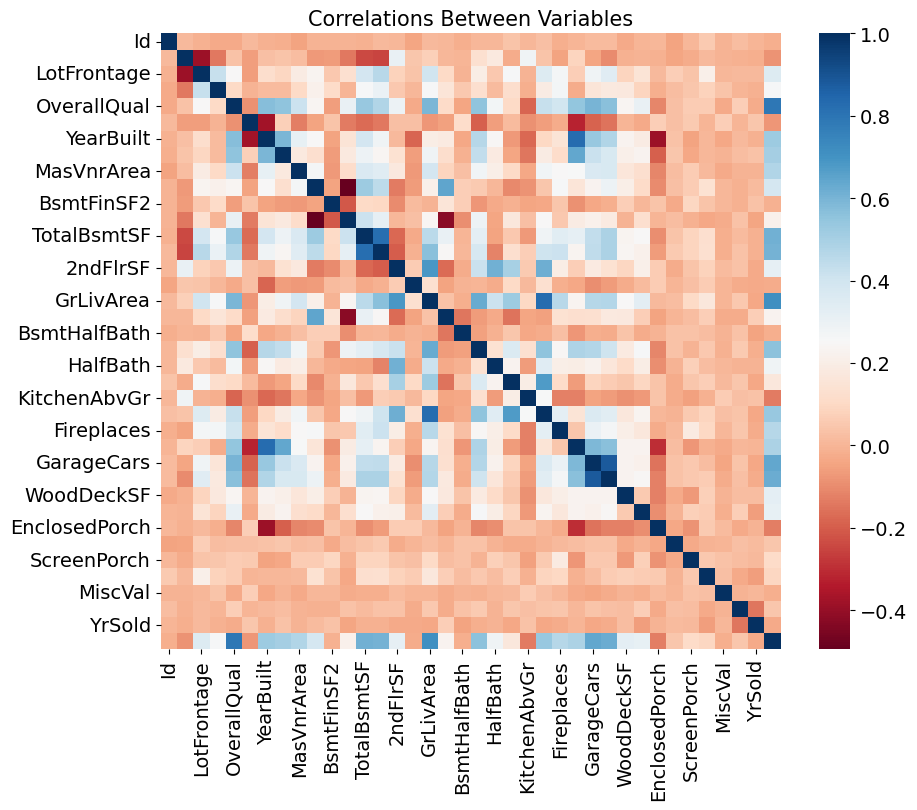

In [41]:
plt.figure(figsize=(10,8))
sns.heatmap(train_df.corr(), cmap="RdBu")
plt.title("Correlations Between Variables", size=15)
plt.show()

In [22]:
important_num_cols = list(train_df.corr()["SalePrice"][(train_df.corr()["SalePrice"]>0.50) | (train_df.corr()["SalePrice"]<-0.50)].index)
important_num_cols

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'GarageArea',
 'SalePrice']

In [ ]:
#important_num_cols = list(df.corr()["SalePrice"][(df.corr()["SalePrice"]>0.50) | (df.corr()["SalePrice"]<-0.50)].index)
#cat_cols = ["MSZoning", "Utilities","BldgType","Heating","KitchenQual","SaleCondition","LandSlope"]
#important_cols = important_num_cols + cat_cols

#df = df[important_cols]

## EDA
### 1) Приводим типы данных

In [42]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 0.90 MB
Memory usage after optimization is: 0.17 MB
Decreased by 80.8%


In [43]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.89 MB
Memory usage after optimization is: 0.19 MB
Decreased by 78.3%


### 2) Визуализируем данные, проверяем данные на логичность и наличие пропусков на основе describe и info, например: площадь не должна быть равна 0, кол-во этажей не может быть 0 и пр.

In [ ]:
#list(set(train_df.dtypes.tolist()))

In [44]:
num_feat = list(train_df.select_dtypes(exclude='category').columns)
category_feat = list(train_df.select_dtypes(include='category').columns)
target = 'Price'


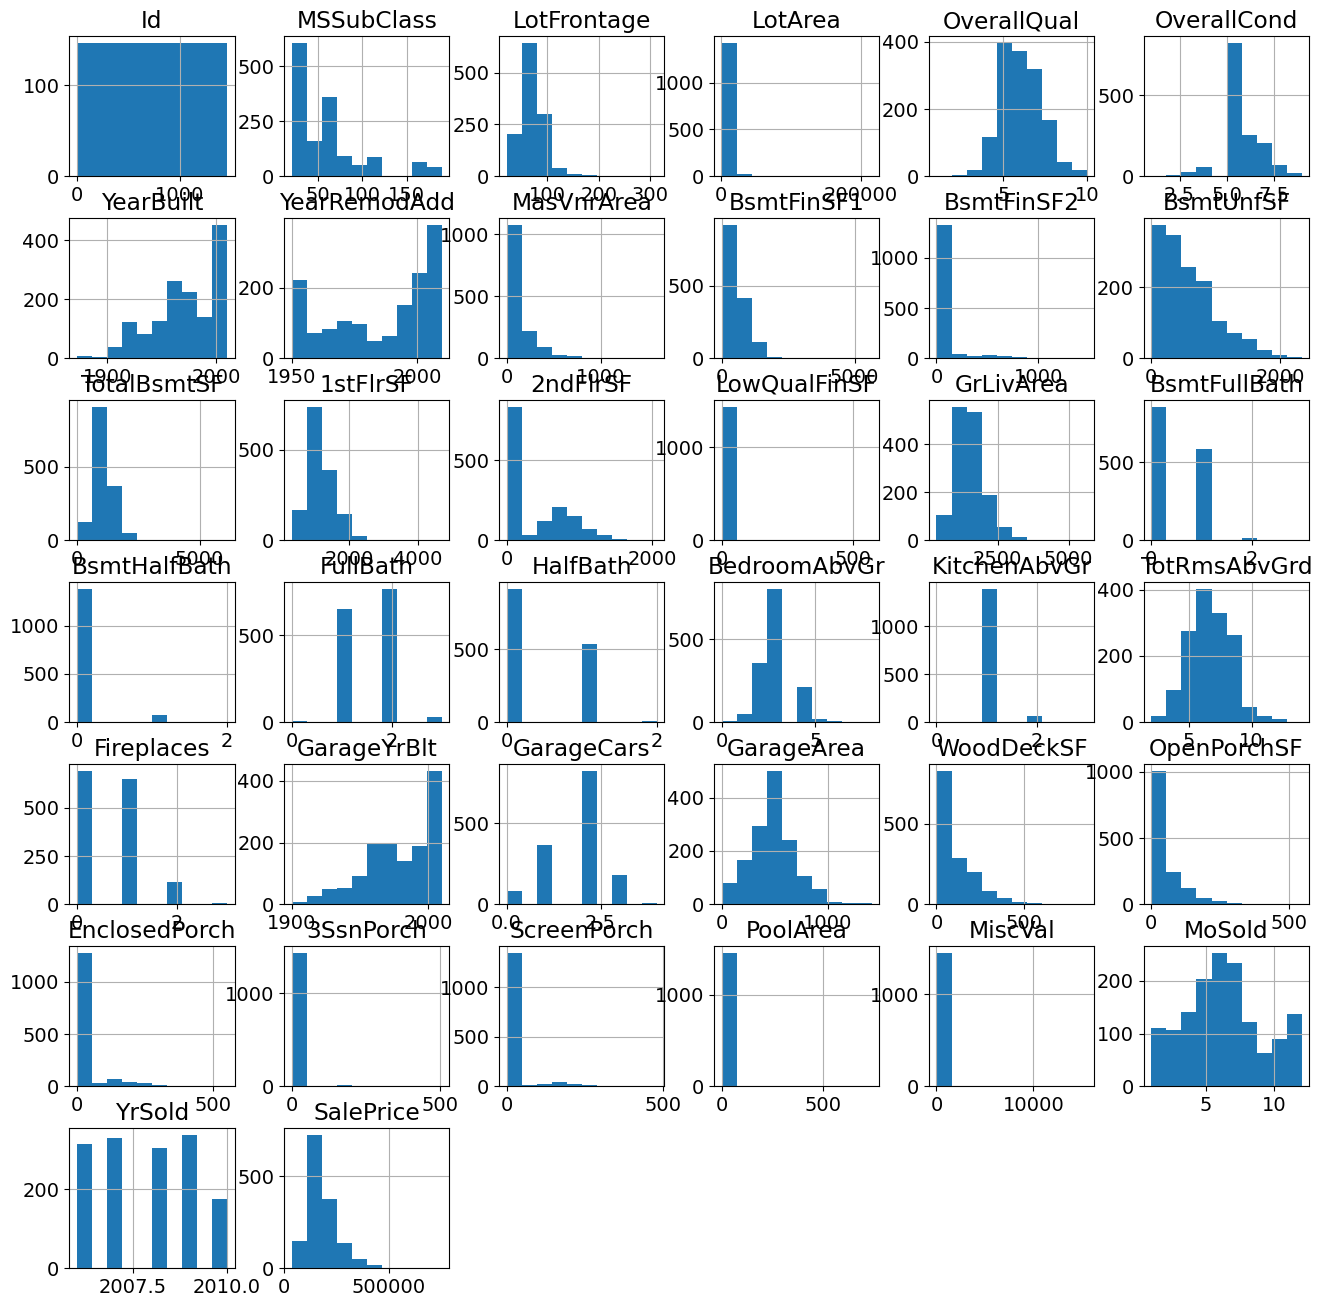

In [45]:
train_df[num_feat].hist(
    figsize=(16,16)
)
plt.show()

In [ ]:
#sns.pairplot(train_df[num_feat])

In [ ]:
plt.figure(figsize=(10,8))
sns.jointplot(x=train_df["OverallQual"], y=train_df["SalePrice"], kind="kde")
sns.jointplot(x=train_df["YearBuilt"], y=train_df["SalePrice"], kind="kde")
sns.jointplot(x=train_df["YearRemodAdd"], y=train_df["SalePrice"], kind="kde")
sns.jointplot(x=train_df["TotalBsmtSF"], y=train_df["SalePrice"], kind="kde")
sns.jointplot(x=train_df["1stFlrSF"], y=train_df["SalePrice"], kind="kde")
sns.jointplot(x=train_df["GrLivArea"], y=train_df["SalePrice"], kind="kde")
sns.jointplot(x=train_df["FullBath"], y=train_df["SalePrice"], kind="kde")
sns.jointplot(x=train_df["TotRmsAbvGrd"], y=train_df["SalePrice"], kind="kde")
sns.jointplot(x=train_df["GarageCars"], y=train_df["SalePrice"], kind="kde")
sns.jointplot(x=train_df["GarageArea"], y=train_df["SalePrice"], kind="kde")
plt.show()

In [46]:
print(train_df['SalePrice'].describe())


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<Axes: xlabel='SalePrice', ylabel='Density'>

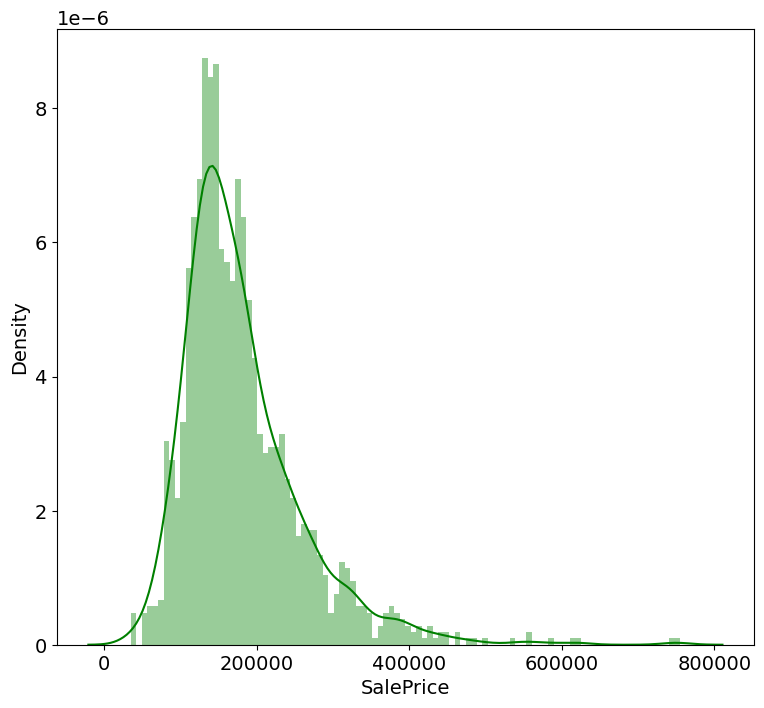

In [47]:
plt.figure(figsize=(9, 8))
sns.distplot(train_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4})

In [48]:
train_df.shape

(1460, 81)

In [49]:
test_df.shape

(1459, 80)

In [50]:
from sklearn.preprocessing import LabelEncoder

In [51]:
class Preproc:   
    
    def fit_emiss(self, data):
        
        #Сохраняем перечень категориальных и числовых переменных
        self.category_feat = list(data.select_dtypes(include='category').columns)
        self.num_feat = list(data.drop(['SalePrice'], axis=1).select_dtypes(exclude='category').columns)  
        
        # медианы                 
        self.medians = data[list(data.drop(['SalePrice'], axis=1).select_dtypes(exclude='category').columns)].median()
        
        
         # подсчет средней цены за м2 по району
       # data_temp = data.loc[((data['Square'] > self.Square_min) & (data['Square'] < self.Square_max))]
       # data_temp["SquareMeterPrice"] = data_temp["Price"] / data_temp["Square"]
       # self.SquareMeterPrice_by_DistrictId = data_temp.groupby('DistrictId', as_index=False)\
       #     .agg({'SquareMeterPrice': 'mean'})\
       #     .rename(columns={'SquareMeterPrice': 'AverageSquareMeterPrice'})

    def transf_emiss(self, data):
            
        #Пропуски
        data[self.num_feat] = data[self.num_feat].fillna(self.medians[self.num_feat])
        
        #Обработки категориальных переменных
        
        data[category_feat] = data[category_feat].apply(LabelEncoder().fit_transform)
        
        #data = pd.concat([data, pd.get_dummies(data[self.category_feat], prefix=self.category_feat )], axis=1)
        
        
        return data
    
    #def features(self, data):
        
        # добавление признака популярности района
        #train_df['DistrictId_counts'] = train_df['DistrictId'].map(self.DistrictId_value_counts)
        #train_df['DistrictId_counts'].fillna(train_df['DistrictId_counts'].median(), inplace=True)
        
        # добавление признака средней стоимости м2 по району
       # data = data.merge(self.SquareMeterPrice_by_DistrictId, on=["DistrictId"], how='left')
       # data['AverageSquareMeterPrice'].fillna(data['AverageSquareMeterPrice'].median(), inplace=True)
        
        # добавление признака среднего значения Healthcare_1 по району
        #train_df = train_df.merge(self.Healthcare_1_by_DistrictId, on=["DistrictId"], how='left')
        #train_df['AverageHealthcare_1'].fillna(train_df['AverageHealthcare_1'].median(), inplace=True)
        
    #    return data


prep = Preproc()    
# тренировочные данные    
prep.fit_emiss(train_df)
train_df = prep.transf_emiss(train_df)
#train_df = prep.features(train_df)

# тренировочные данные   
test_df = prep.transf_emiss(test_df)
#test_df = prep.features(test_df)

In [52]:
#x = train_df.drop(['Price', 'Ecology_2', 'Ecology_3', 'Shops_2'], axis=1)

x = train_df.drop(['SalePrice', 'Id'], axis=1)
y = train_df['SalePrice']

In [53]:
test_id = pd.DataFrame(test_df['Id'])
itog_test = test_df.drop('Id', axis=1)

In [54]:
x.shape

(1460, 79)

In [55]:
itog_test.shape

(1459, 79)

In [56]:
train_df.shape

(1460, 81)

In [57]:
test_df.shape

(1459, 80)

In [58]:
# Для стратификации (сохранения распределения нашего таргета в трейне и тесте) создадим новую переменную, которая 
# разделит наш трагет на 10 квантилей
quantile_bins = pd.qcut(y, q=10, precision=1,labels=False)


In [59]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 21, stratify=quantile_bins)

## Random forest

In [60]:
forest = RandomForestRegressor()

In [61]:
forest.fit(x_train, y_train)

RandomForestRegressor()

Train R2:	0.979
Train RMSE:	11542.422
Train  MSE:	133227494.374
Test R2:	0.842
Test RMSE:	31743.671
Test  MSE:	1007660668.723


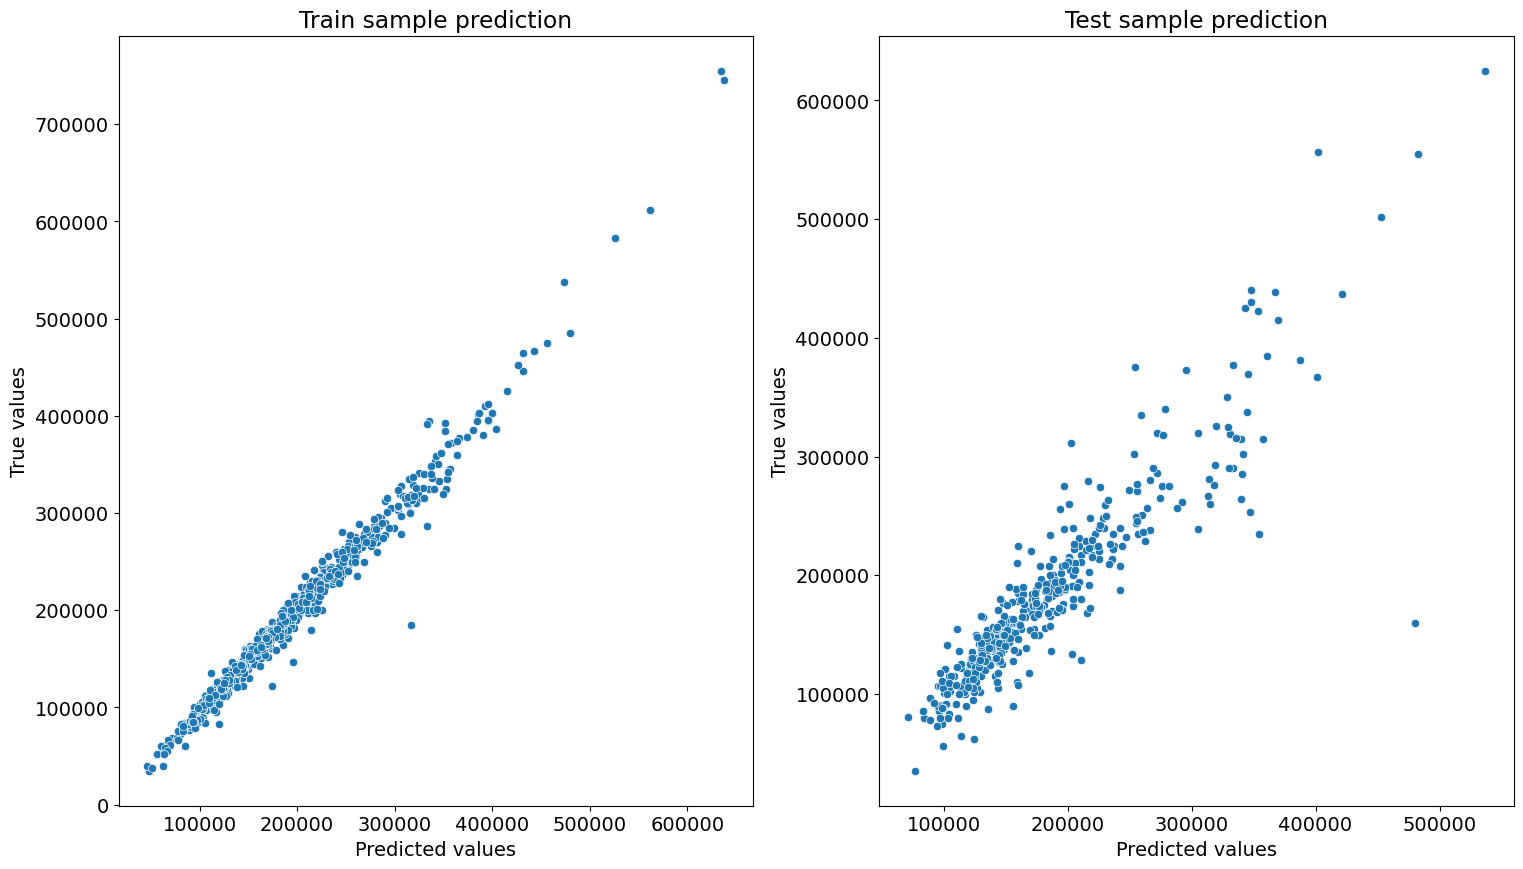

In [62]:
train_pred = forest.predict(x_train)
test_pred = forest.predict(x_test)
evaluate_preds(y_train, train_pred, y_test, test_pred)

In [72]:
rmse_cv(forest, x_train, y_train)

30463.75623565374

In [73]:
rmse_cv(forest, x_test, y_test)

34464.28657369667

In [70]:
evaluation(y_train, train_pred)

(6483.012465753425, 133227494.37361073, 11542.421512560124, 0.9787986758907946)

In [ ]:
evaluation( y_test, test_pred)

## Подберем гиперпараметры для Random Forest

In [373]:
%%time
estimator=RandomForestRegressor(random_state=100)

CPU times: total: 15.6 ms
Wall time: 15.3 ms


In [374]:
parameters = [{'n_estimators': [100, 130], 'max_features': np.arange(2, 7), 'max_depth': np.arange(4, 40)}]

In [375]:
gs = GridSearchCV(estimator, param_grid=parameters, scoring='r2', cv=5 )

In [376]:
%%time
gs.fit(x_train, y_train)

CPU times: total: 9min 26s
Wall time: 9min 28s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=100),
             param_grid=[{'max_depth': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39]),
                          'max_features': array([2, 3, 4, 5, 6]),
                          'n_estimators': [100, 130]}],
             scoring='r2')

In [377]:
gs.best_params_

{'max_depth': 20, 'max_features': 6, 'n_estimators': 100}

## Градиентный бустинг

In [74]:
from sklearn.ensemble import GradientBoostingRegressor

In [76]:
%%time
estimator=GradientBoostingRegressor(random_state=42)

CPU times: total: 0 ns
Wall time: 0 ns


In [83]:
parameters_gb = [{'n_estimators': [160, 300], 'max_features': np.arange(4, 7), 'max_depth': np.arange(4, 15)}]

Train R2:	0.978
Train RMSE:	11817.547
Train  MSE:	139654427.124
Test R2:	0.879
Test RMSE:	27755.592
Test  MSE:	770372894.334


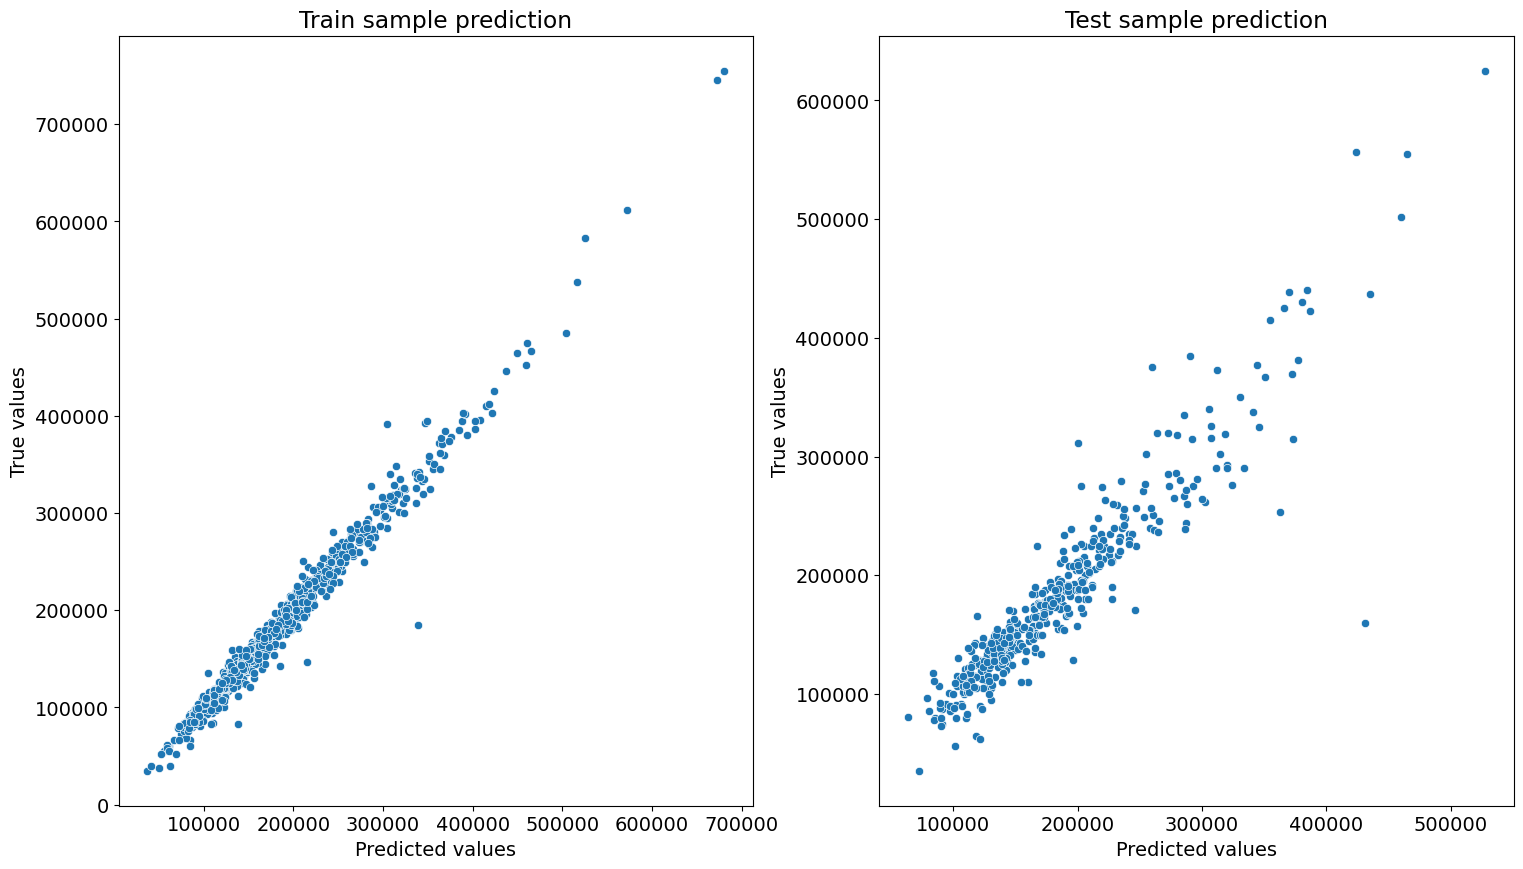

In [84]:
gs_gb = GridSearchCV(estimator, param_grid=parameters_gb, scoring='r2', cv=5 )

In [81]:
gs_gb.best_params_

{'max_depth': 5, 'max_features': 5, 'n_estimators': 300}

In [80]:
%%time
gs_gb.fit(x_train, y_train)

CPU times: total: 2min 32s
Wall time: 2min 41s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             param_grid=[{'max_depth': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                          'max_features': array([4, 5, 6]),
                          'n_estimators': [160, 300]}],
             scoring='r2')

Train R2:	1.0
Train RMSE:	773.427
Train  MSE:	598189.015
Test R2:	0.881
Test RMSE:	27457.694
Test  MSE:	753924941.963


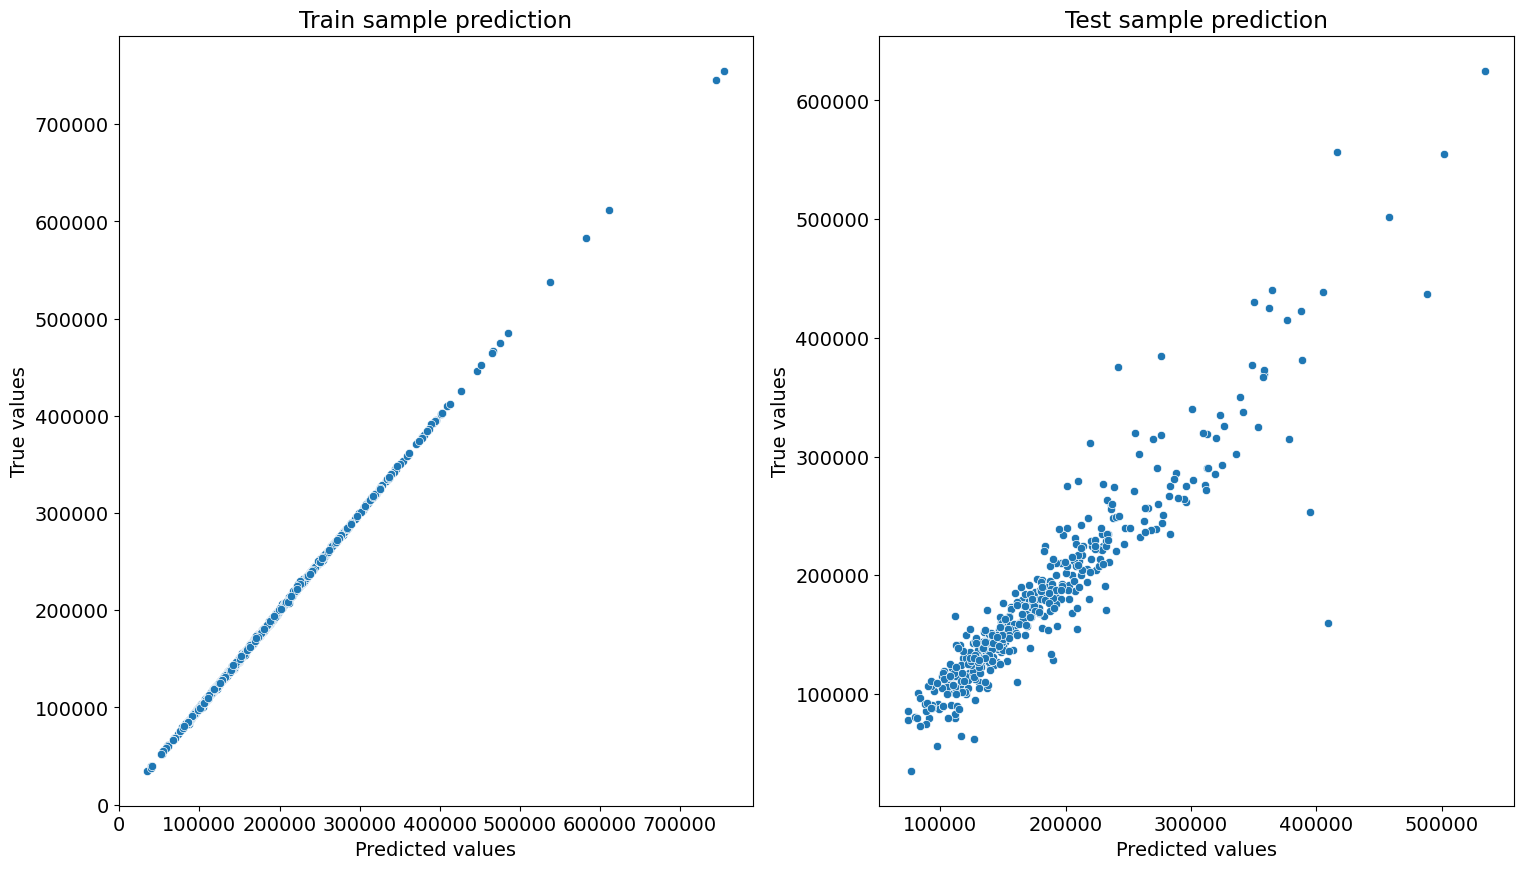

In [85]:
gb_model = GradientBoostingRegressor(criterion='squared_error',
                                     max_depth=5,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=1300,
                                     max_features=5)
gb_model.fit(x_train, y_train)

y_train_preds_gb = gb_model.predict(x_train)

y_test_preds_gb = gb_model.predict(x_test)
evaluate_preds(y_train, y_train_preds_gb, y_test, y_test_preds_gb)

## Строим итоговую модель

In [87]:
#final_model = RandomForestRegressor(n_estimators=100, max_features=6, max_depth=20, random_state=100)

final_model = GradientBoostingRegressor(criterion='squared_error',
                                     max_depth=5,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=1300,
                                     max_features=5)

In [88]:
final_model.fit(x, y)

GradientBoostingRegressor(criterion='squared_error', max_depth=5,
                          max_features=5, min_samples_leaf=10,
                          n_estimators=1300, random_state=42)

In [89]:
#pred = pd.DataFrame(forest.predict(itog_test), columns=['pred'])
#pred
pred = pd.DataFrame(final_model.predict(itog_test), columns=['pred'])
pred

,pred
0,121919.562835
1,167700.407366
2,184483.823354
3,194737.219711
4,178297.970287
...,...
1454,79277.399883
1455,79507.708127
1456,159402.921515
1457,122995.319903


In [90]:
result = test_id.copy()
result['SalePrice'] = pred.copy()

In [384]:
result.head()

,Id,SalePrice
0,1461,130056.922513
1,1462,157715.215620
2,1463,177227.769388
3,1464,186082.508571
4,1465,198216.143863


In [91]:
result.to_csv('Posadskov_house_price_predict_v7.csv', index=False)

#### 